# FPGheArt - Week 5 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


Lavoro:
* Prova con due nodi
* Prova con beta diversi e in posizioni diverse (positive phase o no)
* Controllare il bit correction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
q=0.1
fname = "DATA/dataRBM_q" + str(q) + ".csv"
v = np.loadtxt(fname, delimiter=",", dtype = int)
N = len(v)
L = len(v[0])
print(f"each of N={N} data samples has L={L} digits")
for n in range(10):
    print(v[n])
print("...")

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
else:
    vmin = 0
    GAP = 1
    
#store initial values
v0 = v

for n in range(10):
    print(v[n])
print("...")

each of N=10000 data samples has L=8 digits
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
...
[-1  1 -1 -1  1 -1  1  1]
[ 1  1 -1  1  1 -1 -1  1]
[-1  1  1  1 -1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1 -1]
[ 1  1 -1 -1  1 -1 -1 -1]
[-1  1  1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1 -1  1  1]
[ 1 -1 -1  1  1  1 -1  1]
[ 1 -1 -1 -1 -1 -1  1 -1]
...


In [3]:
def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x, y)

def mycolor(val):
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(w, a, b, epoch=0, M = 3, L = 8):
    A = 2./w.max()
    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder = 1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s = A*np.abs(a[i]), zorder = 2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s = A*np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()
    
def activate(v_in, wei, bias, DE, beta = 1, info = False):
    act = np.dot(v_in, wei) + bias
    prob = 1./(1.+np.exp(-beta*DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print("input =\n", v_in)
        print("act =\n", act)
        print("prob = \n", prob)
        print("out = \n", v_out)
    return v_out

In [4]:
def create_RBM(M = 3, L = 8):
    sigma = np.sqrt(4./float(L+M))
    np.random.seed(12345)
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    return w, a, b

def train_RBM(v, l_rate = 1, mini = 500, nepoch = 50, beta = 1, beta_h = 1, M = 3, L = 8):
    np.random.seed(12345)
    GAP = v[0].max() - v[0].min()
    w, a, b = create_RBM(M, L)
    m = 0
    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M))

            #positive CD phase
            h = activate(v[n], w, b, GAP, beta_h)
            #negative CD phase
            vf = activate(h, w.T, a, GAP, beta)
            # positive CD pahse nr 2
            hf = activate(vf, w, b, GAP, beta_h)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m+=1

            if m == mini:
                C = l_rate/mini
                dw = C*(vh_data-vh_model)
                da = C*(v_data-v_model)
                db = C*(h_data-h_model)
                w += dw
                a += da
                b += db
                m = 0
        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate/(0.05*l_rate + 1)
        if epoch%50 == 0:
            plotgraph(w, a, b, epoch, M, L)
            print("l_rate = ", l_rate)
    return w, a, b

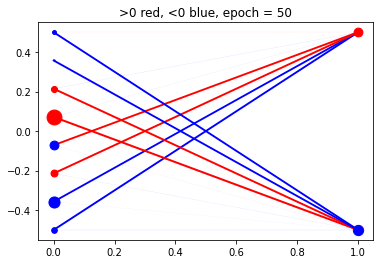

l_rate =  0.28571428571428586


In [5]:
w,a,b = train_RBM(v, M = 2)

In [6]:
v1 = np.full((N, L), vmin)
for n in range(N):
    h = activate(v0[n], w, b, GAP)
    v1[n] = activate(h, w.T, a, GAP)

seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
count = 0
for n in range(N):
    for i in range(len(seq)):
        if (v0[n] == seq[i]).all():
            count += 1
            break

print(count/N)

for n in range(N):
    for i in range(len(seq)):
        if (v1[n] == seq[i]).all():
            count += 1
            break

print(count/N)

0.4322
0.867


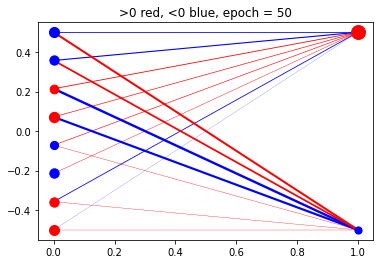

l_rate =  0.28571428571428586


In [7]:
w,a,b = train_RBM(v, M = 2, beta = 10, beta_h = 10)

In [8]:
v1 = np.full((N, L), vmin)
for n in range(N):
    h = activate(v0[n], w, b, GAP, beta = 10)
    v1[n] = activate(h, w.T, a, GAP, beta = 10)

seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
count = 0
for n in range(N):
    for i in range(len(seq)):
        if (v0[n] == seq[i]).all():
            count += 1
            break

print(count/N)

for n in range(N):
    for i in range(len(seq)):
        if (v1[n] == seq[i]).all():
            count += 1
            break

print(count/N)

0.4322
0.614


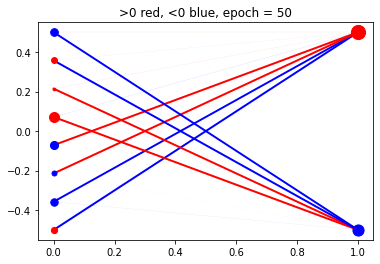

l_rate =  0.28571428571428586


In [9]:
w,a,b = train_RBM(v, M = 2, beta = 0.1, beta_h = 0.1)

In [10]:
v1 = np.full((N, L), vmin)
for n in range(N):
    h = activate(v0[n], w, b, GAP, beta = 0.1)
    v1[n] = activate(h, w.T, a, GAP, beta = 0.1)

seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
count = 0
for n in range(N):
    for i in range(len(seq)):
        if (v0[n] == seq[i]).all():
            count += 1
            break

print(count/N)

for n in range(N):
    for i in range(len(seq)):
        if (v1[n] == seq[i]).all():
            count += 1
            break

print(count/N)

0.4322
0.8687


In [11]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]

def test_RBM(v0, seq, w, a, b, beta = 1, beta_h = 1):
    v1 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w, b, GAP, beta = beta_h)
        v1[n] = activate(h, w.T, a, GAP, beta = beta)
    count = 0
    for n in range(N):
        for i in range(len(seq)):
            if (v1[n] == seq[i]).all():
                count += 1
                break
    return count/N

In [13]:
score = test_RBM(v0, seq, w, a, b, 0.1, 0.1)
print(score)

4309


In [14]:
betas = [0.01, 0.1, 1, 10, 50]

beta =  0.01


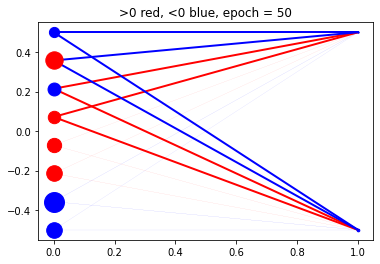

l_rate =  0.28571428571428586
beta =  0.1


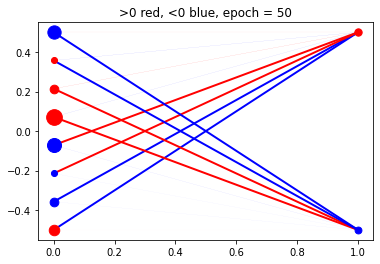

l_rate =  0.28571428571428586
beta =  1


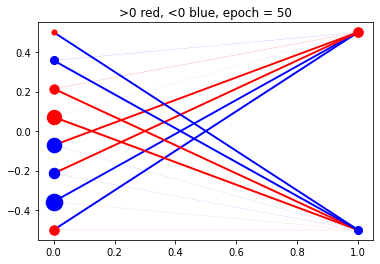

l_rate =  0.28571428571428586
beta =  10


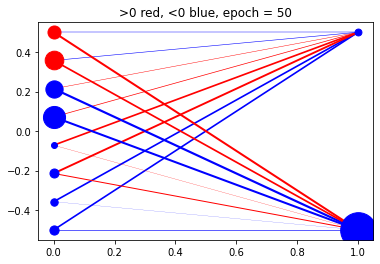

l_rate =  0.28571428571428586
beta =  50


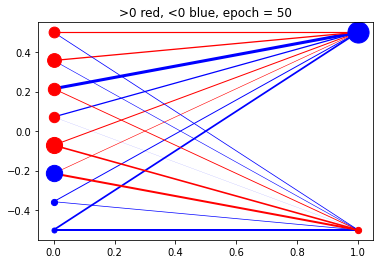

l_rate =  0.28571428571428586


In [18]:
scores = []
for beta in betas:
    print('beta = ', beta)
    w,a,b = train_RBM(v, M = 2, beta = beta)
    scores.append(test_RBM(v0, seq, w, a, b, beta = beta))

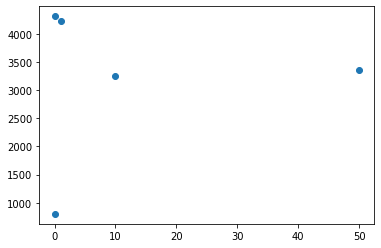

In [20]:
plt.scatter(betas, scores)